In [1]:
cd ../..

/Users/joeranbosma/stack/Projects/M5Forecast


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt
from tqdm import tqdm

from tensorflow.keras.layers import (Dense, Dropout, Flatten, Input, BatchNormalization, Lambda, 
                                     concatenate, Embedding, Reshape)
from tensorflow.keras.models import Model, load_model, clone_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback, LearningRateScheduler

import wandb
from wandb.keras import WandbCallback

# own imports
from evaluation import Referee, load_data, select_dates, select_day_nums
from train import BatchCreator, Logger, plot_confidence_series, plot_some_confidence_intervals
from model_builder import get_pinball_losses, Dist4, Dist2, Direct
from flow import model_predict, denorm_preds, warp_preds_to_ref_form, plot_some, evaluate_model
from preprocess import preprocess, get_features, pandas_cat_data, reset_categorical_features


# Setup file paths
data_dir = 'data/'
os.environ['DATA_DIR'] = data_dir
sub_dir = 'submissions_uncertainty/final/'
plt.rcParams['font.size'] = 13

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Combine predictions of all levels

In [3]:
# Load in the data set
calendar, sales_train_validation, sell_prices = load_data()

sales_true = select_dates(sales_train_validation, day_end=1913, num_days=28, include_metadata=True)
sales_train = select_dates(sales_train_validation, day_start=1, num_days=1913-28, include_metadata=True)

ref = Referee(sales_true, sales_train, sell_prices, calendar, verbose=True)

Initializing Referee
Converting true sales to quantile form
Calculating weights for each level...
Calculating scale for each level...
Finished setup.


## Setup

For each level:  

1. Read the (prepared) dataset
2. Get the validation batch creator
3. Get the denormalised predictions
4. Save to file

Then:

1. Combine predictions

In [4]:
# Set input sizes for the model
input_shapes = {
    1: (178,),
    2: (181,),
    3: (191,),
    4: (181,),
    5: (188,),
    6: (184,),
    7: (191,),
    8: (194,),
    9: (201,),
    10: (3237,),
    11: (3240,),
    12: (3248,), # 3255
}

augment_events = False
lgb_prediction = True
if lgb_prediction:
    # add one to the input shape
    for key, val in input_shapes.items():
        input_shapes[key] = (val[0]+1,)

# select whether to perform the category-reset step of the preprocessing
# reset_categories = {d: False if d in [3] else True for d in range(1, 1+12)}
reset_categories = {d: True for d in range(1, 1+12)}

# select which model function was used to build the model
models_base = {
    1: Dist2(inp_shape=input_shapes[1], num_nodes=4),
    2: Dist2(inp_shape=input_shapes[2], num_nodes=6),
    3: Dist2(inp_shape=input_shapes[3], num_nodes=6),
    4: Dist2(inp_shape=input_shapes[4], num_nodes=6),
    5: Dist2(inp_shape=input_shapes[5], num_nodes=6),
    6: Dist2(inp_shape=input_shapes[6], num_nodes=6),
    7: Dist2(inp_shape=input_shapes[7], num_nodes=32),
    8: Dist2(inp_shape=input_shapes[8], num_nodes=32),
    9: Dist2(inp_shape=input_shapes[9], num_nodes=32),
   10: Direct(inp_shape=input_shapes[10], num_nodes=64),
   11: Direct(inp_shape=input_shapes[11], num_nodes=64),
   12: Direct(inp_shape=input_shapes[12], num_nodes=64),
}

# select the trained models
model_path = 'models/uncertainty/final/'
lgb_prediction_dir = model_path + "run2/"
# models_weights = {
#     1: model_path + 'train_multiple_levels/run1/level1_stepped_lr_part3_WSPL0.055553566486644584.h5',
#     2: model_path + 'train_multiple_levels/run2/level2_stepped_lr_part3_WSPL9.30e-02.h5',
#     3: model_path + 'training_scheme/try1/level3_nodes6_part1_WSPL1.05e-01.h5',
#     4: model_path + 'train_multiple_levels/run3/level4_stepped_lr_part3_WSPL7.16e-02.h5',
#     5: model_path + 'train_multiple_levels/run3/level5_stepped_lr_part3_WSPL9.83e-02.h5',
#     6: model_path + 'train_multiple_levels/run3/level6_stepped_lr_part3_WSPL9.16e-02.h5',
#     7: model_path + 'train_multiple_levels/run2/level7_stepped_lr_part3_WSPL1.36e-01.h5',
#     8: model_path + 'train_multiple_levels/run3/level8_stepped_lr_part2_WSPL1.36e-01.h5',
#     9: model_path + 'train_multiple_levels/run4/level9_stepped_lr_part3_WSPL1.47e-01.h5',
#    10: model_path + 'hyper_opt/level_10/model_direct_dist_256_manual_lr_to_1e-3_finetune_bs5k.h5',
#    11: model_path + 'hyper_opt/level_11/direct256_stepped_lr_part2.h5',
#    12: model_path + 'training_scheme/try1/best_model_level12.h5',
# }

In [8]:
def find_model_fn(model_path, level, prediction_lag):
    # find model fn
    model_path_base = model_path
    if level <= 9:
        model_path_base += "mlp-run1"
    else:
        model_path_base += "mlp-run2"
    model_path_base += "/lag{}/".format(prediction_lag)
    
    # get list of files
    fn_list = os.listdir(model_path_base)

    model_fn_base = "level{}_stepped_lr_part3_WSPL".format(level)
    fn_list_mask = [(model_fn_base in fn) for fn in fn_list]
    
    assert np.sum(fn_list_mask), "None or multiple models found in {}".format(model_fn_base)
    idx = np.argmax(fn_list_mask)
    fn = fn_list[idx]
    return model_path_base + fn

In [9]:
all_collected_dfs = {}

In [10]:
for prediction_lag in [28, 21, 14, 7, 3, 2, 1]:
    print(">>>>> Starting lag {} <<<<<".format(prediction_lag))
    collected_dfs = {}
    
    for level in range(1, 12+1):
        if prediction_lag <= 21 and level >= 10:
            continue
        
        print("=== Starting level {} ===".format(level))
        ###################
        #### READ DATA ####
        ###################

        fn = data_dir + 'eval_prep/level_{}_simple_fe_2016_04_24_2016_05_22_normalised_demand_lag_{}.pickle'.format(
            level, prediction_lag)

        # check if already preprocessed
        assert os.path.exists(fn), "Run preprocess_validation_features.ipynb first"

        print("Reading from file..")
        data = pd.read_pickle(fn)
        
        print("Adding LightGBM evaluation predictions..")
        fn = lgb_prediction_dir + "eval_predictions_level{}_lag{}.csv".format(level, prediction_lag)
        lgb_pred = pd.read_csv(fn, index_col=0)
        data['lgb_pred'] = lgb_pred['lgb_pred'].values
        
        # select features
        features = get_features(level=level, prediction_lag=prediction_lag, 
                                sell_price_features=('sell_price' in data.columns))

        cat_features = [
            "item_id",
            "dept_id",
            "cat_id",
            "store_id",
            "state_id",
            "event_name_1",
            "event_type_1",
            "event_name_2",
            "event_type_2",
            # time features.
            "year",
            "month",
            "week",
            "day",
            "dayofweek",
        ]

        available_cat_features = [f for f in cat_features if f in data.columns]
        
        if lgb_prediction and not 'lgb_pred' in features:
            features.append('lgb_pred')

        ########################
        #### GET GENERATORS ####
        ########################
        # going to evaluate with the last 28 days
        test = data[(data['date'] > '2016-04-24')]

        # get generators
        labels = ['demand']
        batch_size = 1024
        test_batch_creator = BatchCreator(test, features, labels, shuffle=False, ensure_all_samples=True,
                                          categorical_features=available_cat_features, batch_size=batch_size, 
                                          check_nan=False)

        # determine model input shape
        x, y = next(test_batch_creator.flow())
        INP_SHAPE = x[0].shape

        # make losses
        losses = get_pinball_losses()

        print("Input size level {}: {}".format(level, INP_SHAPE))


        #########################
        #### GET PREDICTIONS ####
        #########################
        print("Reading model..")
        model_fn = find_model_fn(model_path, level, prediction_lag)
        
        model = clone_model(models_base[level])
        model.load_weights(model_fn)
        
        df = evaluate_model(model, ref, test_batch_creator, calendar, quantiles, data_dir, level, 
                                     validation_set=True, verbose=False)

        collected_dfs[level] = df
        
        del data, test, test_batch_creator
        gc.collect()
    
    all_collected_dfs[prediction_lag] = collected_dfs

>>>>> Starting lag 28 <<<<<
=== Starting level 1 ===
Reading from file..
Adding LightGBM evaluation predictions..
Input size level 1: (179,)
Reading model..
Predicting...
Denormalising...
Warping predictions...
=== Starting level 2 ===
Reading from file..
Adding LightGBM evaluation predictions..
Input size level 2: (182,)
Reading model..
Predicting...
Denormalising...
Warping predictions...
=== Starting level 3 ===
Reading from file..
Adding LightGBM evaluation predictions..
Input size level 3: (192,)
Reading model..
Predicting...
Denormalising...
Warping predictions...
=== Starting level 4 ===
Reading from file..
Adding LightGBM evaluation predictions..
Input size level 4: (182,)
Reading model..
Predicting...
Denormalising...
Warping predictions...
=== Starting level 5 ===
Reading from file..
Adding LightGBM evaluation predictions..
Input size level 5: (189,)
Reading model..
Predicting...
Denormalising...
Warping predictions...
=== Starting level 6 ===
Reading from file..
Adding Light

=== Starting level 6 ===
Reading from file..
Adding LightGBM evaluation predictions..
Input size level 6: (185,)
Reading model..
Predicting...
Denormalising...
Warping predictions...
=== Starting level 7 ===
Reading from file..
Adding LightGBM evaluation predictions..
Input size level 7: (192,)
Reading model..
Predicting...
Denormalising...
Warping predictions...
=== Starting level 8 ===
Reading from file..
Adding LightGBM evaluation predictions..
Input size level 8: (195,)
Reading model..
Predicting...
Denormalising...
Warping predictions...
=== Starting level 9 ===
Reading from file..
Adding LightGBM evaluation predictions..
Input size level 9: (202,)
Reading model..
Predicting...
Denormalising...
Warping predictions...
>>>>> Starting lag 2 <<<<<
=== Starting level 1 ===
Reading from file..
Adding LightGBM evaluation predictions..
Input size level 1: (179,)
Reading model..
Predicting...
Denormalising...
Warping predictions...
=== Starting level 2 ===
Reading from file..
Adding LightG

### Combine predictions and create submission

In [11]:
predictions = {}

# collect predictions and reset index
for prediction_lag in [28, 21, 14, 7, 3, 2, 1]:
    print(all_collected_dfs[prediction_lag].keys())
    preds = pd.concat(all_collected_dfs[prediction_lag].values())
    preds.index = range(len(preds.index))
    
    predictions[prediction_lag] = preds

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9])


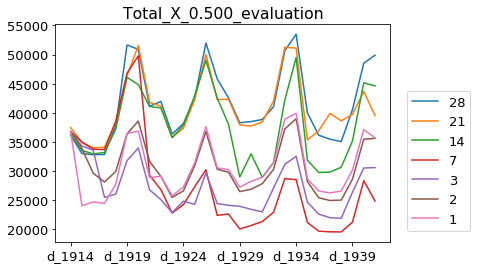

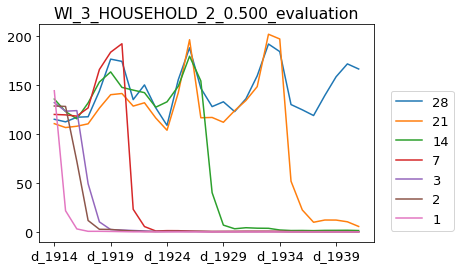

In [12]:
final_preds = predictions[28].copy()

for serie_id in ['Total_X_0.500_evaluation', 'WI_3_HOUSEHOLD_2_0.500_evaluation']:

    final_preds[final_preds.id == serie_id].iloc[0, :28].plot(label=28)
    for prediction_lag in [21, 14, 7, 3, 2, 1]:
        preds = predictions[prediction_lag]
        preds[preds.id == serie_id].iloc[0, :28].plot(label=prediction_lag)
    plt.legend(loc=(1.05, 0.05))
    plt.title(serie_id)
    plt.show()

In [13]:
final_preds = predictions[28].copy()

for prediction_lag in [21, 14, 7, 3, 2, 1]:
    preds = predictions[prediction_lag]
    
    day_nums = select_day_nums(preds)
    d_cols = ['d_%d'%d for d in day_nums[:prediction_lag]]
    print("Setting {} days: {}".format(len(d_cols), d_cols))
    
    idx = preds.index
    final_preds.loc[idx, d_cols] = preds.loc[idx, d_cols]

Setting 21 days: ['d_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919', 'd_1920', 'd_1921', 'd_1922', 'd_1923', 'd_1924', 'd_1925', 'd_1926', 'd_1927', 'd_1928', 'd_1929', 'd_1930', 'd_1931', 'd_1932', 'd_1933', 'd_1934']
Setting 14 days: ['d_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919', 'd_1920', 'd_1921', 'd_1922', 'd_1923', 'd_1924', 'd_1925', 'd_1926', 'd_1927']
Setting 7 days: ['d_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919', 'd_1920']
Setting 3 days: ['d_1914', 'd_1915', 'd_1916']
Setting 2 days: ['d_1914', 'd_1915']
Setting 1 days: ['d_1914']


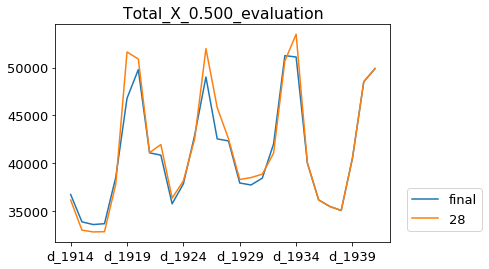

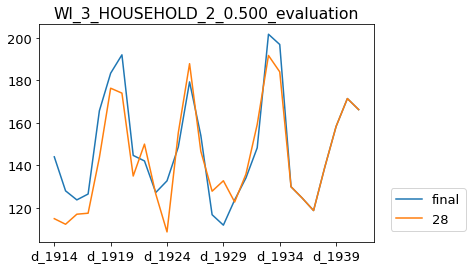

In [14]:
for serie_id in ['Total_X_0.500_evaluation', 'WI_3_HOUSEHOLD_2_0.500_evaluation']:
    final_preds[final_preds.id == serie_id].iloc[0, :28].plot(label='final')
    
    predictions[28][predictions[28].id == serie_id].iloc[0, :28].plot(label=28)
    plt.legend(loc=(1.05, 0.05))
    plt.title(serie_id)
    plt.show()

In [15]:
preds = final_preds
preds.shape

(385560, 31)

In [17]:
from flow import create_uncertainty_submission_from_ref_format

In [23]:
preds.to_csv(sub_dir + "final_pred2.csv")

In [25]:
fn = create_uncertainty_submission_from_ref_format(
            preds, submission_dir=sub_dir, filename="final-a", add_timestamp=True)

In [26]:
!kaggle competitions submit -c m5-forecasting-uncertainty -f $fn -m "Final predictions (a)"

100%|███████████████████████████████████████| 39.4M/39.4M [01:16<00:00, 542kB/s]
Successfully submitted to M5 Forecasting - Uncertainty

#### Lag of 28 days only

In [16]:
prediction_lag = 28
preds = pd.concat(all_collected_dfs[prediction_lag].values())
preds

,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,...,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,id,quantile,level
0,32433.733788,30483.323228,29882.557310,30190.023792,33248.093315,49728.956985,48882.068504,38678.999616,39741.268787,33485.246372,...,36410.093152,32984.601286,32329.851220,32650.287675,37156.615249,46119.706201,47737.102534,Total_X_0.005_evaluation,0.005,1
1,33321.871765,31086.265019,30584.726393,30825.078460,34337.294877,50184.287308,49362.438414,39261.417267,40269.971715,34170.786059,...,37271.199835,33744.059252,33081.649295,33226.556269,37967.707557,46692.884920,48253.780185,Total_X_0.025_evaluation,0.025,1
2,34743.552112,32051.417972,31708.711222,31841.627024,36080.820199,50913.150050,50131.380865,40193.717272,41116.287240,35268.152259,...,38649.608284,34959.747901,34285.084167,34149.006870,39266.052080,47610.393767,49080.843671,Total_X_0.165_evaluation,0.165,1
3,35176.342714,32345.228977,32050.879120,32151.088624,36611.589865,51135.034484,50365.464509,40477.528813,41373.926921,35602.216907,...,39069.224285,35329.830402,34651.439037,34429.820618,39661.296944,47889.703502,49332.620775,Total_X_0.250_evaluation,0.250,1
4,36148.309763,33005.081090,32819.323643,32846.082101,37803.596291,51633.339996,50891.173055,41114.919646,41952.531680,36352.459813,...,40011.609016,36160.969386,35474.198524,35060.479205,40548.943816,48516.982325,49898.064573,Total_X_0.500_evaluation,0.500,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274405,0.010202,0.005097,0.005022,0.005159,0.007420,0.009943,0.008480,0.004690,0.004322,0.004343,...,0.016749,0.015213,0.014299,0.013293,0.019184,0.020355,0.018980,HOUSEHOLD_2_516_WI_3_0.500_evaluation,0.500,12
274406,0.157782,0.136254,0.139999,0.139768,0.169401,0.227719,0.214608,0.136843,0.134172,0.125290,...,0.143470,0.125956,0.120066,0.115547,0.155621,0.157607,0.156007,HOUSEHOLD_2_516_WI_3_0.750_evaluation,0.750,12
274407,0.274553,0.224974,0.230194,0.229854,0.277028,0.370633,0.345038,0.229500,0.220410,0.212189,...,0.285510,0.253176,0.240510,0.233652,0.306282,0.314578,0.308280,HOUSEHOLD_2_516_WI_3_0.835_evaluation,0.835,12
274408,2.069814,2.126013,2.149022,2.073367,2.335390,2.945682,3.359093,2.173443,2.105100,2.143959,...,2.255876,2.005599,1.950301,1.929907,2.262307,2.327747,2.263254,HOUSEHOLD_2_516_WI_3_0.975_evaluation,0.975,12


In [18]:
fn = create_uncertainty_submission_from_ref_format(
            preds, submission_dir=sub_dir, filename="final-28-lightgbm", add_timestamp=True)

In [19]:
!kaggle competitions submit -c m5-forecasting-uncertainty -f $fn -m "Final predictions, 28 day lag, LightGBM"

100%|███████████████████████████████████████| 39.4M/39.4M [01:37<00:00, 424kB/s]
Successfully submitted to M5 Forecasting - Uncertainty